# STAT5243 Project 4: Causal Inference

**Group 2:**

    Wendy Doan
    Yibai Liu
    Yiwen Fang
    Shuqi Yu
    Zhihang Xia

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
# train-test split for propensity score
from sklearn.model_selection import train_test_split

# propensity score from tree models
from sklearn.ensemble import GradientBoostingClassifier

# Stratification and Regression Adjustment
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression



In [3]:
# baseline propensity score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV


## Intro

## Exploring the data

In [5]:
highDim_dataset = pd.read_csv('../data/highDim_dataset.csv')
lowDim_dataset = pd.read_csv('../data/lowDim_dataset.csv')

In [6]:
highDim_dataset.shape

(2000, 187)

In [7]:
highDim_dataset.head()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185
0,41.224513,0,0,1,4,18,17,-1,1,0.75,...,8,10,8,9,8,-1,-1,-1,-1,-1
1,40.513875,0,0,0,1,10,6,-1,10,0.35,...,6,5,6,8,5,-1,-1,-1,-1,-1
2,38.495476,0,0,0,16,8,4,4,4,0.40,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,33.001889,0,1,0,3,10,2,-1,5,0.41,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,37.043603,0,1,1,11,21,10,10,20,0.43,...,6,8,7,7,7,6,7,6,6,7


In [8]:
lowDim_dataset.shape

(500, 24)

In [9]:
lowDim_dataset.head()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,30.486999,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,9.09,1.149622
1,18.208417,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,1.40,...,0.7,0.00,1.40,0.0,1.40,0.0,0.00,0.00,0.00,2.887702
2,13.485040,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,3.57,0.0,0.00,0.0,0.00,0.00,0.00,0.000000
3,25.699678,1,2.38,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,2.38,0.0,2.38,0.0,0.00,0.00,0.00,0.405465
4,23.752968,0,0.15,0.15,0.05,0.1,0.0,0.42,0.1,0.95,...,0.0,0.36,3.16,0.0,1.58,0.0,0.52,0.31,0.00,1.574639


In [1]:
plt.plot(highDim_dataset[highDim_dataset.A == 1].Y, 'o')
plt.plot(highDim_dataset[highDim_dataset.A == 0].Y, 'ro')
plt.title("High-dimension data distribution")
plt.show()

NameError: name 'plt' is not defined

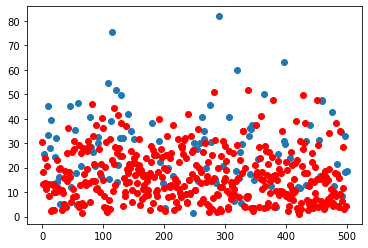

In [12]:
plt.plot(lowDim_dataset[lowDim_dataset.A == 1].Y, 'o')
plt.plot(lowDim_dataset[lowDim_dataset.A == 0].Y, 'ro')
plt.show()

#### Naive estimate of ATE

In [ ]:
def naive_ATE(dataset):
    return np.average(dataset[dataset.A == 1].Y) - np.average(dataset[dataset.A == 0].Y)

In [11]:
np.average(highDim_dataset[highDim_dataset.A == 1].Y) - np.average(highDim_dataset[highDim_dataset.A == 0].Y)

-75.17133436876799

Naive estimate of ATE

In [13]:
np.average(lowDim_dataset[lowDim_dataset.A == 1].Y) - np.average(lowDim_dataset[lowDim_dataset.A == 0].Y)

10.602068661915688

### Are the data sets balanced? 

In [ ]:
# For Chloe: go ahead if you want to resample/reweigh

In [14]:
print(len(highDim_dataset[highDim_dataset.A == 1]), len(highDim_dataset[highDim_dataset.A == 0]))

643 1357


In [15]:
print(len(lowDim_dataset[lowDim_dataset.A == 1]), len(lowDim_dataset[lowDim_dataset.A == 0]))

106 394


Slightly imbalanced, but acceptable.

### Split into train and test set 80:20

In [16]:
X_high = highDim_dataset.iloc[:, 2:]
y_high = highDim_dataset.Y

In [17]:
X_low = lowDim_dataset.iloc[:, 2:]
y_low = lowDim_dataset.Y

In [18]:
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=0.2, random_state=42)
X_low_train, X_low_test, y_low_train, y_low_test = train_test_split(X_low, y_low, test_size=0.2, random_state=24)

Note that to get the score, we won't be fitting X versus y, but rather X versus Z, where Z is the covariate label. This is encoded in the current `X` array. 

In [19]:
def split_z_X(X_original:pd.DataFrame):
    """ Split the first column, stored in z """
    z, X = X_original.iloc[:, 0].copy(), X_original.iloc[:, 1:].copy()
    return z, X

In [20]:
z_high_train, X_high_train = split_z_X(X_high_train)
z_high_test, X_high_test = split_z_X(X_high_test)
z_low_train, X_low_train = split_z_X(X_low_train)
z_low_test, X_low_test = split_z_X(X_low_test)

## Propensity Score - Logistic Regression

In [ ]:
# Chloe: feel free to apply cross validation here

High dimensional data baseline

In [21]:
logisticRegr_high = LogisticRegression(max_iter=10000)

In [22]:
logisticRegr_high.fit(X_high_train, z_high_train)

LogisticRegression(max_iter=10000)

In [23]:
logisticRegr_high.score(X_high_train, z_high_train)

0.748125

In [24]:
logisticRegr_high.score(X_high_test, z_high_test)

0.71

Low dimensional data baseline

In [25]:
logisticRegr_low = LogisticRegression()

In [26]:
logisticRegr_low.fit(X_low_train, z_low_train)

LogisticRegression()

In [27]:
logisticRegr_low.score(X_low_train, z_low_train)

0.795

In [28]:
logisticRegr_low.score(X_low_test, z_low_test)

0.86

## Propensity Score - Tree Stump

In [29]:
# Chloe to fill in, some basic code follows
# Need to optimize and perform feature selection through a feature grid

High dimensional data

In [126]:
clf_high = GradientBoostingClassifier(
    n_estimators=20, lea_depth=1,rning_rate=1.0, max random_state=0
).fit(X_high_train, z_high_train)

In [127]:
clf_high.score(X_high_train, z_high_train)

0.73625

In [128]:
clf_high.score(X_high_test, z_high_test)

0.7325

Low dimensional data

In [33]:
clf_low = GradientBoostingClassifier(
    n_estimators=10, learning_rate=1.0, max_depth=1, random_state=0
).fit(X_low_train, z_low_train)

In [34]:
clf_low.score(X_low_train, z_low_train)

0.84

In [35]:
clf_low.score(X_low_test, z_low_test)

0.83

The propensity score is the predicted probability

In [36]:
propensity_score_high_train = np.exp(clf_high.predict_log_proba(X_high_train))[:, 1]
propensity_score_low_train = np.exp(clf_low.predict_log_proba(X_low_train))[:, 1]

In [37]:
final_data_high_train = pd.DataFrame(
    np.array([propensity_score_high_train, z_high_train, y_high_train]).T,
    columns=['e', 'z', 'y']
)

In [55]:
final_data_high_train

,e,z,y
0,0.070647,0.0,47.338744
1,0.759728,1.0,-90.864079
2,0.102187,0.0,35.825645
3,0.256375,0.0,33.243630
4,0.185472,0.0,32.249539
...,...,...,...
1595,0.424859,0.0,25.520535
1596,0.398745,0.0,32.519383
1597,0.515632,0.0,-12.147964
1598,0.094283,0.0,39.649836


In [38]:
final_data_low_train = pd.DataFrame(
    np.array([propensity_score_low_train, z_low_train, y_low_train]).T,
    columns=['e', 'z', 'y']
)

In [129]:
final_data_low_train

,e,z,y
0,0.284916,0.0,12.877969
1,0.228317,0.0,32.802694
2,0.512505,1.0,29.490731
3,0.228317,0.0,21.650569
4,0.100827,0.0,27.907869
...,...,...,...
395,0.100827,0.0,18.991806
396,0.350639,1.0,35.834414
397,0.699851,1.0,30.971844
398,0.100827,1.0,25.676471


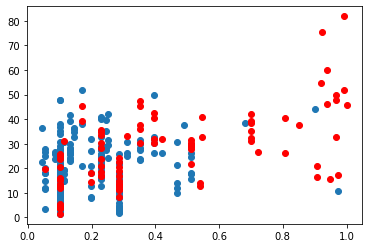

In [40]:
plt.plot(final_data_low_train[final_data_low_train.z==0].e, 
         final_data_low_train[final_data_low_train.z==0].y, 'o')
plt.plot(final_data_low_train[final_data_low_train.z==1].e, 
         final_data_low_train[final_data_low_train.z==1].y, 'ro')
plt.show()

## ATE Estimate - Stratification

In [42]:
def Stratify(data:pd.DataFrame, k:int):
    
    data_copy = data.copy()
    
    # rank to resolve duplicate edge cases
    data_copy['bin'] = pd.qcut(
        data_copy.e.rank(method='first'), k, labels=False
    )
    
    return data_copy

In [133]:
Stratify(final_data_high_train, 5).head()

,e,z,y,bin
0,0.070647,0.0,47.338744,0
1,0.759728,1.0,-90.864079,4
2,0.102187,0.0,35.825645,0
3,0.256375,0.0,33.243630,2
4,0.185472,0.0,32.249539,1


In [119]:
def Calculate_ATE_Strat(data:pd.DataFrame, k:int):
    
    n = data.shape[0]
    
    data_copy = Stratify(data, k)
    
    # calculate ATE score
    ATE = 0
    for k_idx in range(k):
        
        # temporary data frame
        Qj = data_copy[data_copy.bin == k_idx]
        nj = Qj.shape[0]

        # !!! Need to check the arithmetic here !!!
        ATE += (nj/n) * ( np.average(Qj[Qj.z==1].y) - np.average(Qj[Qj.z==0].y) )
    
    return ATE

In [120]:
Calculate_ATE_Strat(final_data_high_train, 5)

-59.24443120078578

In [121]:
Calculate_ATE_Strat(final_data_low_train, 5)

2.9986594169229432

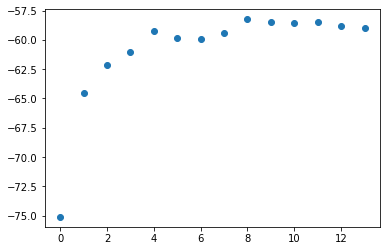

In [134]:
# Graph as functions of bins
plt.plot([Calculate_ATE_Strat(final_data_high_train, k) for k in range(1, 15)], 'o')
plt.show()

## ATE Estimate - Stratification with Regression Adjustment

In [48]:
# Wendy to fill in

In [116]:
def Calculate_ATE_StratRegrAdjusted(data:pd.DataFrame, X_data, k:int):
    
    n = data.shape[0]
    
    data_adjusted = pd.concat(
        [Stratify(data, k), X_data.reset_index(drop=True)], axis=1)
    
    # calculate ATE score
    ATE = 0
    for k_idx in range(k):
        
        # temporary data frame
        Qj = data_adjusted[data_adjusted.bin == k_idx]
        nj = Qj.shape[0]
 
        # Regression Adjusted Linearly, then Delta_j = alpha^Z_j
        X = Qj.drop(['e', 'y', 'bin'], axis=1)
        y = Qj.y
        reg = LinearRegression().fit(X, y)
        
        ATE += reg.coef_[0]
    
    return ATE / k

In [137]:
Calculate_ATE_StratRegrAdjusted(final_data_high_train, X_high_train, 1)

-59.57714111051057

In [138]:
Calculate_ATE_StratRegrAdjusted(final_data_low_train, X_low_train, 1)

2.4902369721808086

In [117]:
Calculate_ATE_StratRegrAdjusted(final_data_high_train, X_high_train, 5)

-54.51211689365348

In [118]:
Calculate_ATE_StratRegrAdjusted(final_data_low_train, X_low_train, 5)

1.9847333675465868

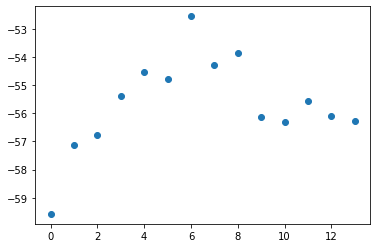

In [136]:
# Graph as functions of bins
plt.plot([Calculate_ATE_StratRegrAdjusted(final_data_high_train, X_high_train, k) for k in range(1, 15)], 'o')
plt.show()